In [1]:
import os
import re
import glob
from datetime import datetime
import sys
import itertools
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
sys.path.append("..") # Adds higher directory to python modules path for importing from src dir

from src.algorithms import SimpleLSTM, MLPClassifier, SVC, Heuristic
from src.datasets import NyseStocksDataset
from src.evaluation import Evaluator
from src.utils import print_metrics_as_md, pandas_df_to_markdown_table
# from src.pipeline import run_pipeline, prepare_data, evaluate_results
# from src.experiments import get_metrics

%matplotlib inline
%load_ext autotime
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


## 1. 15 runs

- SimpleLSTM with seeds from 42 to 56
- On OC-3C and OC-3C+
- 90k train, 9k test
- 512 batch size
- 150 epochs

| -  |   datasets    predictors     |     OC-3C    SLSTM_42   |     OC-3C    SLSTM_43   |     OC-3C    SLSTM_44   |     OC-3C    SLSTM_45   |     OC-3C    SLSTM_46   |     OC-3C    SLSTM_47   |     OC-3C    SLSTM_48   |     OC-3C    SLSTM_49   |     OC-3C    SLSTM_50   |     OC-3C    SLSTM_51   |     OC-3C    SLSTM_52   |     OC-3C    SLSTM_53   |     OC-3C    SLSTM_54   |     OC-3C    SLSTM_55   |     OC-3C    SLSTM_56   |     OC-3C+    SLSTM_42   |     OC-3C+    SLSTM_43   |     OC-3C+    SLSTM_44   |     OC-3C+    SLSTM_45   |     OC-3C+    SLSTM_46   |     OC-3C+    SLSTM_47   |     OC-3C+    SLSTM_48   |     OC-3C+    SLSTM_49   |     OC-3C+    SLSTM_50   |     OC-3C+    SLSTM_51   |     OC-3C+    SLSTM_52   |     OC-3C+    SLSTM_53   |     OC-3C+    SLSTM_54   |     OC-3C+    SLSTM_55   |     OC-3C+    SLSTM_56   |
|---:|:-----------------------------|------------------------:|------------------------:|------------------------:|------------------------:|------------------------:|------------------------:|------------------------:|------------------------:|------------------------:|------------------------:|------------------------:|------------------------:|------------------------:|------------------------:|------------------------:|-------------------------:|-------------------------:|-------------------------:|-------------------------:|-------------------------:|-------------------------:|-------------------------:|-------------------------:|-------------------------:|-------------------------:|-------------------------:|-------------------------:|-------------------------:|-------------------------:|-------------------------:|
|  0 | prec                         |                 0.36441 |                 0.35397 |                 0.38462 |                 0.36813 |                 0.37811 |                 0.37419 |                 0.38523 |                 0.34052 |                 0.3722  |                 0.39108 |                 0.35703 |                 0.38181 |                 0.36864 |                 0.34628 |                 0.37142 |                  0.22822 |                  0.32555 |                  0.36945 |                  0.36879 |                  0.31527 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |
|  1 | rec                          |                 0.37278 |                 0.35878 |                 0.381   |                 0.37911 |                 0.38744 |                 0.38322 |                 0.37844 |                 0.36167 |                 0.37011 |                 0.38311 |                 0.37022 |                 0.37833 |                 0.37867 |                 0.36544 |                 0.37789 |                  0.34022 |                  0.33311 |                  0.37656 |                  0.37322 |                  0.34011 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |
|  2 | f1                           |                 0.29667 |                 0.24276 |                 0.29404 |                 0.31864 |                 0.3297  |                 0.31781 |                 0.2985  |                 0.26826 |                 0.2745  |                 0.29808 |                 0.28126 |                 0.29798 |                 0.31248 |                 0.28542 |                 0.30624 |                  0.19255 |                  0.2956  |                  0.29925 |                  0.28082 |                  0.19564 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |
|  3 | acc                          |                 0.37278 |                 0.35878 |                 0.381   |                 0.37911 |                 0.38744 |                 0.38322 |                 0.37844 |                 0.36167 |                 0.37011 |                 0.38311 |                 0.37022 |                 0.37833 |                 0.37867 |                 0.36544 |                 0.37789 |                  0.34022 |                  0.33311 |                  0.37656 |                  0.37322 |                  0.34011 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |
|  4 | mcc                          |                 0.07882 |                 0.06828 |                 0.10221 |                 0.08302 |                 0.09732 |                 0.09366 |                 0.094   |                 0.06191 |                 0.08404 |                 0.10601 |                 0.07855 |                 0.09329 |                 0.08554 |                 0.06459 |                 0.08684 |                  0.03069 |                 -0.00037 |                  0.08678 |                  0.08774 |                  0.02772 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |


**Outcome**: Execution became very slow after a few iterations. Had to stop after 20 out of 30. Nevertheless OC-3C+ appears to be worse. The histories show that a the accuracy is not changing at all (especially on OC-3+) -> lower batch size / higher learning rate?

**Winner**: OC-3C

[comment]: <> (Execution Code: print_metrics_as_md "../reports/custom/prices-15-runs.csv")

## 2. 5 runs (bs=64)

- SimpleLSTM with seeds from 42 to 46
- On OC-3C and OC-3C+
- 60k train, 6k test
- 64 batch size
- 150 epochs

| -  |   datasets    predictors     |     OC-3C    SLSTM_b64_42   |     OC-3C    SLSTM_b64_43   |     OC-3C    SLSTM_b64_44   |     OC-3C    SLSTM_b64_45   |     OC-3C    SLSTM_b64_46   |     OC-3C+    SLSTM_b64_42   |     OC-3C+    SLSTM_b64_43   |     OC-3C+    SLSTM_b64_44   |     OC-3C+    SLSTM_b64_45   |     OC-3C+    SLSTM_b64_46   |
|---:|:-----------------------------|----------------------------:|----------------------------:|----------------------------:|----------------------------:|----------------------------:|-----------------------------:|-----------------------------:|-----------------------------:|-----------------------------:|-----------------------------:|
|  0 | prec                         |                     0.11111 |                     0.32211 |                     0.22711 |                     0.31561 |                     0.23353 |                      0.11111 |                      0.11111 |                      0.36631 |                            0 |                            0 |
|  1 | rec                          |                     0.33333 |                     0.34283 |                     0.33767 |                     0.3465  |                     0.33883 |                      0.33333 |                      0.33333 |                      0.37983 |                            0 |                            0 |
|  2 | f1                           |                     0.16667 |                     0.30668 |                     0.1786  |                     0.21627 |                     0.18374 |                      0.16667 |                      0.16667 |                      0.31404 |                            0 |                            0 |
|  3 | acc                          |                     0.33333 |                     0.34283 |                     0.33767 |                     0.3465  |                     0.33883 |                      0.33333 |                      0.33333 |                      0.37983 |                            0 |                            0 |
|  4 | mcc                          |                     0       |                     0.01561 |                     0.02991 |                     0.04257 |                     0.03177 |                      0       |                      0       |                      0.08696 |    

**Outcome**: Same problems. Even worse results for OC-3C

**Winner**: -

[comment]: <> (Execution Code: print_metrics_as_md "../reports/custom/prices-5-runs-bs64.csv")

## 3. 5 runs (bs=16)

- SimpleLSTM with seeds from 42 to 46
- On OC-3C and OC-3C+
- 45k train, 4.5k test
- 16 batch size
- 100 epochs

| -  |   datasets    predictors     |     OC-3C    SLSTM_b16_42   |     OC-3C    SLSTM_b16_43   |     OC-3C    SLSTM_b16_44   |     OC-3C    SLSTM_b16_45   |     OC-3C    SLSTM_b16_46   |     OC-3C+    SLSTM_b16_42   |     OC-3C+    SLSTM_b16_43   |     OC-3C+    SLSTM_b16_44   |     OC-3C+    SLSTM_b16_45   |     OC-3C+    SLSTM_b16_46   |
|---:|:-----------------------------|----------------------------:|----------------------------:|----------------------------:|----------------------------:|----------------------------:|-----------------------------:|-----------------------------:|-----------------------------:|-----------------------------:|-----------------------------:|
|  0 | prec                         |                     0.25112 |                     0.11111 |                     0.11111 |                     0.11111 |                     0.11111 |                      0.11111 |                      0.11111 |                      0.2391  |                      0.11111 |                      0.11111 |
|  1 | rec                          |                     0.34022 |                     0.33333 |                     0.33333 |                     0.33333 |                     0.33333 |                      0.33333 |                      0.33333 |                      0.33867 |                      0.33333 |                      0.33333 |
|  2 | f1                           |                     0.18983 |                     0.16667 |                     0.16667 |                     0.16667 |                     0.16667 |                      0.16667 |                      0.16667 |                      0.1848  |                      0.16667 |                      0.16667 |
|  3 | acc                          |                     0.34022 |                     0.33333 |                     0.33333 |                     0.33333 |                     0.33333 |                      0.33333 |                      0.33333 |                      0.33867 |                      0.33333 |                      0.33333 |
|  4 | mcc                          |                     0.03562 |                     0       |                     0       |                     0       |                     0       |                      0       |                      0       |                      0.03018 |                      0       |                      0       |


**Outcome**: Same problems. Even worse results for OC-3C

**Winner**: -

[comment]: <> (Execution Code: print_metrics_as_md "../reports/custom/prices-5-runs-bs16.csv")

Failed settings:
- n_units=[128, 128], lstm_dropout=0.4, lr=0.001, bs=16, epoch=20, 45k
- n_units=[256, 256], bs=64, epoch=10, 150k

# 4. 2 runs on new test data

- SimpleLSTM with seeds from 42 to 43, Heuristics, MLP, SVC
- On OCM-3C
- 240k train, 48k test (not balanced)
- 64 batch size
- 100 epochs
- 64 & 64 units
- 0.001 learning rate

|  -   |     OCM-3C    SLSTM_s42   |     OCM-3C    SLSTM_s43   |     OCM-3C    Heuristic_all   |     OCM-3C    Heuristic_l1   |     OCM-3C    Heuristic_l3   |     OCM-3C    MLP   |     OCM-3C    SVC   |
|:-----|-------------------------:|-------------------------:|-----------------------------:|----------------------------:|----------------------------:|--------------------:|--------------------:|
| prec |                  0.50297 |                  0.50447 |                      0.48738 |                     0.49216 |                     0.47567 |             0.50176 |             0.46663 |
| rec  |                  0.56846 |                  0.56006 |                      0.61102 |                     0.49181 |                     0.57175 |             0.4454  |             0.62292 |
| f1   |                  0.52308 |                  0.52249 |                      0.49012 |                     0.49198 |                     0.50026 |             0.4658  |             0.47941 |
| acc  |                  0.56846 |                  0.56006 |                      0.61102 |                     0.49181 |                     0.57175 |             0.4454  |             0.62292 |
| mcc  |                  0.08959 |                  0.09124 |                      0.03097 |                     0.06258 |                     0.03274 |             0.06744 |             0.00323 |

## Current Execution

In [3]:
datasets = [
    # NyseStocksDataset('OC-3C', file_path='../data/nyse/prices.csv', epsilon=0.0055, companies=['GOOGL', 'GOOG', 'AXP', 'GM', 'WMT', 'AMZN', 'APC', 'MSFT']),
    NyseStocksDataset('OCM-3C', file_path='../data/nyse/prices.csv', features=['open', 'close', 'movement']),
    NyseStocksDataset('OCMvOC-3C', file_path='../data/nyse/prices.csv', features=['open', 'close', 'vix_open', 'vix_close', 'movement']),
    # NyseStocksDataset('OC-3C+', file_path='../data/nyse/prices-split-adjusted.csv'),
]
[ds.load() for ds in datasets];


time: 20.9 s


In [ ]:
def get_predictors(n_features, n_timestamps=7, n_classes=3):
    seeds = range(42, 47)
    return [
        Heuristic('_l1', n_features, n_timestamps, Heuristic.last_movement),
        Heuristic('_all', n_features, n_timestamps, Heuristic.mean_movement),
        Heuristic('_l3', n_features, n_timestamps, Heuristic.last_three_movements),
        Heuristic('_v_l1', n_features, n_timestamps, Heuristic.last_vix_movement),
        MLPClassifier(),
        SVC(),
        *[SimpleLSTM(f'_s{s}', epochs=100, n_timestamps=n_timestamps, n_features=n_features, n_classes=n_classes, seed=s, batch_size=64,
                    n_units=[64, 64], lr=0.001) for s in seeds]
    ]
evaluator = Evaluator('all-baselines', datasets, get_predictors, '../reports', seed=42, store=True,
                      n_train_samples=300000, n_test_samples=60000, downsample=True)
metrics = evaluator()

In [ ]:
metrics

In [ ]:
print_metrics_as_md('../reports/custom/all-baselines.csv')

In [ ]:
# SimpleLSTM(f'_s{s}', epochs=400, n_timestamps=n_timestamps, n_features=n_features,
#            n_classes=n_classes, seed=s, batch_size=256, n_units=[256, 256], lr=0.0001)

# evaluator.plot_histories()

In [4]:
def get_predictors(n_features, n_timestamps=7, n_classes=3):
    seeds = range(42, 47)
    return [
#         Heuristic('_l1', n_features, n_timestamps, Heuristic.last_movement),
#         Heuristic('_all', n_features, n_timestamps, Heuristic.mean_movement),
#         Heuristic('_l3', n_features, n_timestamps, Heuristic.last_three_movements),
#         Heuristic('_v_l1', n_features, n_timestamps, Heuristic.last_vix_movement),
        MLPClassifier(),
#         SVC(),
        *[SimpleLSTM(f'_s{s}', epochs=100, n_timestamps=n_timestamps, n_features=n_features, n_classes=n_classes, seed=s, batch_size=128,
                    n_units=[128, 128], lr=0.001) for s in seeds]
    ]
evaluator = Evaluator('ml-baselines-2', datasets, get_predictors, '../reports', seed=42, store=True,
                      n_train_samples=300000, n_test_samples=60000, downsample=True)
metrics = evaluator()

2018-12-21 18:56:19 [INFO] src.evaluation.evaluator: ---------- Prepare dataset ----------
2018-12-21 18:56:20 [INFO] src.preparation: Train Labels --> -1.0: 100000; 0.0: 100000; 1.0: 100000
2018-12-21 18:56:20 [INFO] src.preparation: Training range: 2010-01-13 00:00:00 to 2014-06-27 00:00:00
2018-12-21 18:56:20 [INFO] src.preparation: Test Labels --> -1.0: 10302; 0.0: 37490; 1.0: 12208
2018-12-21 18:56:20 [INFO] src.preparation: Testing range: 2016-01-04 00:00:00 to 2016-12-30 00:00:00
2018-12-21 18:56:20 [INFO] src.preparation: Done preparing data
2018-12-21 18:56:20 [INFO] src.evaluation.evaluator: ---------- MLP | OCM-3C ----------


Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.

2018-12-21 19:01:33 [INFO] src.evaluation.evaluator: ---------- SLSTM_s42 | OCM-3C ----------



2018-12-21 21:40:18 [INFO] src.evaluation.evaluator: ---------- SLSTM_s43 | OCM-3C ----------



2018-12-22 00:22:09 [INFO] src.evaluation.evaluator: ---------- SLSTM_s44 | OCM-3C ----------



2018-12-22 03:14:42 [INFO] src.evaluation.evaluator: ---------- SLSTM_s45 | OCM-3C ----------



2018-12-22 06:11:04 [INFO] src.evaluation.evaluator: ---------- SLSTM_s46 | OCM-3C ----------



2018-12-22 09:15:27 [INFO] src.evaluation.evaluator: ---------- Prepare dataset ----------
2018-12-22 09:15:27 [INFO] src.preparation: Train Labels --> -1.0: 100000; 0.0: 100000; 1.0: 100000
2018-12-22 09:15:27 [INFO] src.preparation: Training range: 2010-01-04 00:00:00 to 2014-06-09 00:00:00
2018-12-22 09:15:27 [INFO] src.preparation: Test Labels --> -1.0: 10137; 0.0: 37433; 1.0: 12430
2018-12-22 09:15:27 [INFO] src.preparation: Testing range: 2016-01-04 00:00:00 to 2016-12-30 00:00:00
2018-12-22 09:15:28 [INFO] src.preparation: Done preparing data
2018-12-22 09:15:28 [INFO] src.evaluation.evaluator: ---------- MLP | OCMvOC-3C ----------


c:\users\thomas\hpi\ma\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



2018-12-22 09:24:06 [INFO] src.evaluation.evaluator: ---------- SLSTM_s42 | OCMvOC-3C ----------



2018-12-22 12:34:33 [INFO] src.evaluation.evaluator: ---------- SLSTM_s43 | OCMvOC-3C ----------


User Interaction: Stopped earlier!
2018-12-22 14:09:51 [INFO] src.evaluation.evaluator: ---------- SLSTM_s44 | OCMvOC-3C ----------


SystemError: <built-in function TF_NewBuffer> returned a result with an error set

time: 19h 13min 33s


In [5]:
evaluator._metrics

datasets     OCM-3C                                                    \
predictors      MLP SLSTM_s42 SLSTM_s43 SLSTM_s44 SLSTM_s45 SLSTM_s46   
prec        0.50620   0.50170   0.50005   0.49935   0.50105   0.50210   
rec         0.38905   0.55497   0.55277   0.55835   0.55803   0.56537   
f1          0.41822   0.52137   0.51972   0.51997   0.52126   0.52347   
acc         0.38905   0.55497   0.55277   0.55835   0.55803   0.56537   
mcc         0.05772   0.08206   0.07897   0.07759   0.08078   0.08343   

datasets   OCMvOC-3C                                                    
predictors       MLP SLSTM_s42 SLSTM_s43 SLSTM_s44 SLSTM_s45 SLSTM_s46  
prec         0.37399   0.44839   0.47712         0         0         0  
rec          0.21137   0.29092   0.33253         0         0         0  
f1           0.18204   0.31150   0.35872         0         0         0  
acc          0.21137   0.29092   0.33253         0         0         0  
mcc         -0.03582  -0.01074   0.02517         0         0         0

time: 217 ms


2018-12-22 14:11:41 [INFO] src.evaluation.plotter: Stored plot at ../reports\figures/exp-ml-baselines-2\histories\history--MLP-on-OCM-3C-2018-12-22-141141.png
2018-12-22 14:11:41 [INFO] src.evaluation.plotter: Stored plot at ../reports\figures/exp-ml-baselines-2\histories\history--SLSTM_s42-on-OCM-3C-2018-12-22-141141.png
2018-12-22 14:11:41 [INFO] src.evaluation.plotter: Stored plot at ../reports\figures/exp-ml-baselines-2\histories\history--SLSTM_s43-on-OCM-3C-2018-12-22-141141.png
2018-12-22 14:11:42 [INFO] src.evaluation.plotter: Stored plot at ../reports\figures/exp-ml-baselines-2\histories\history--SLSTM_s44-on-OCM-3C-2018-12-22-141142.png
2018-12-22 14:11:42 [INFO] src.evaluation.plotter: Stored plot at ../reports\figures/exp-ml-baselines-2\histories\history--SLSTM_s45-on-OCM-3C-2018-12-22-141142.png
2018-12-22 14:11:42 [INFO] src.evaluation.plotter: Stored plot at ../reports\figures/exp-ml-baselines-2\histories\history--SLSTM_s46-on-OCM-3C-2018-12-22-141142.png
2018-12-22 14:11

TypeError: 'NoneType' object is not subscriptable

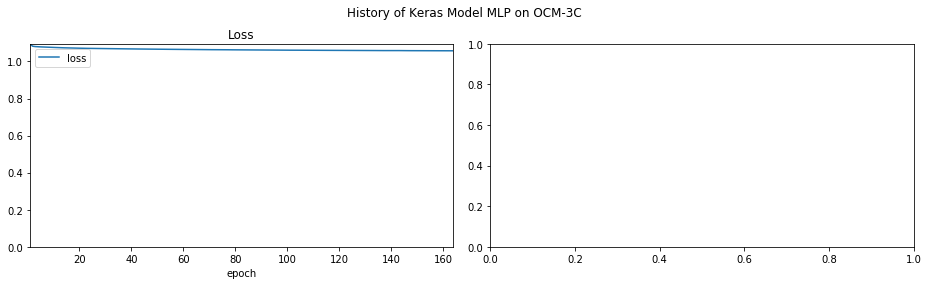

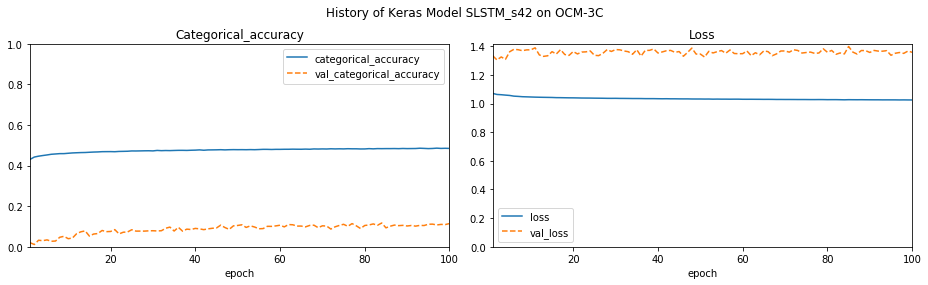

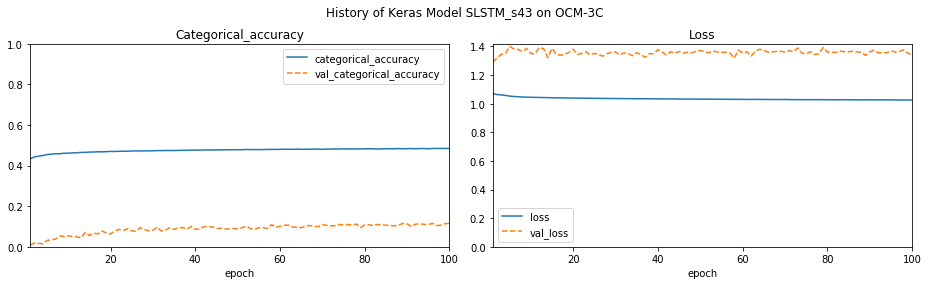

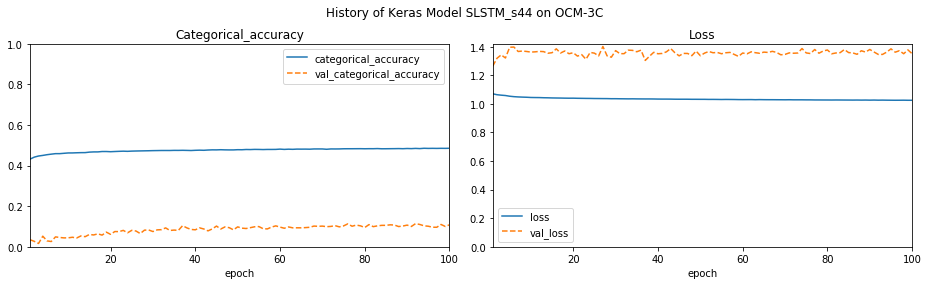

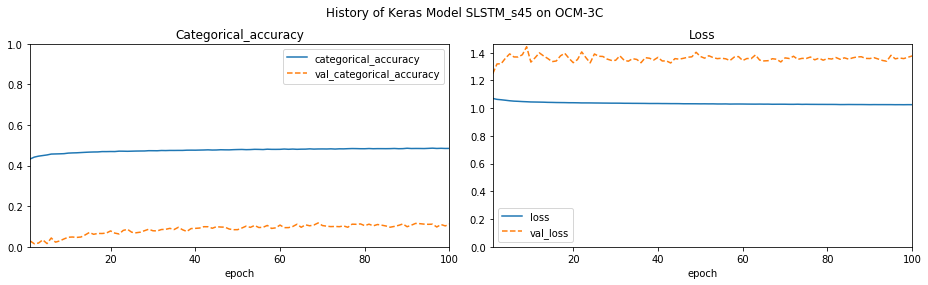

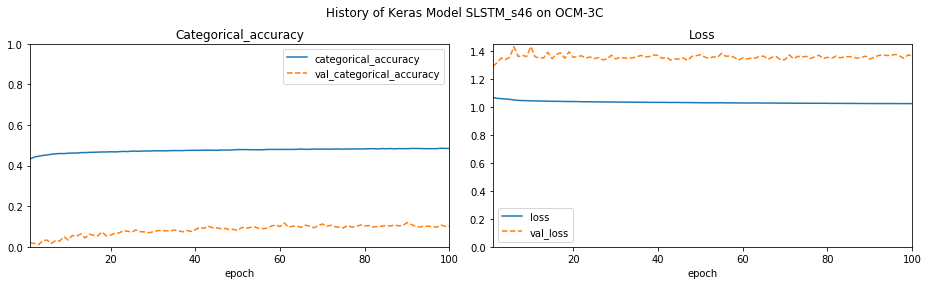

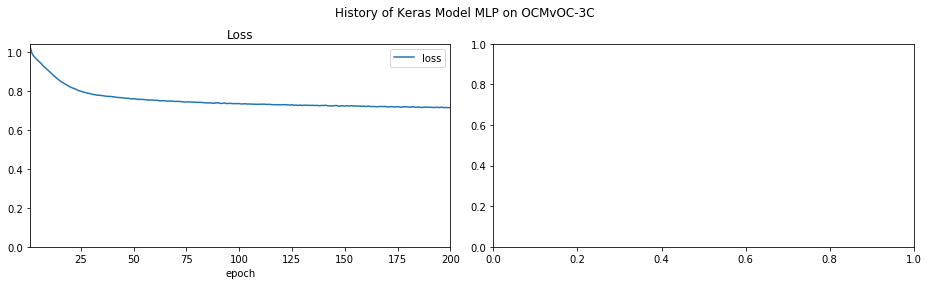

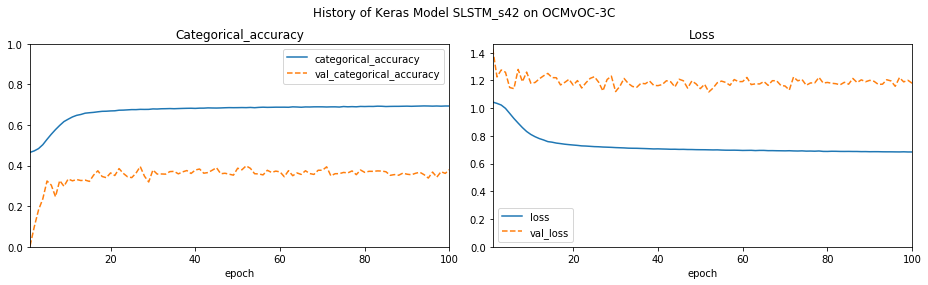

time: 4.1 s


In [7]:
evaluator._metrics.to_csv(os.path.join(evaluator.output_dir, f'custom/{evaluator.name}.csv'))
evaluator.plot_histories()